### Importing Libraries

In [18]:
import string
import numpy as np

### Data Pre processing

In [19]:
with open("full_set.txt") as f:
    content = f.readlines()
content[0:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0\n',
 'Good case, Excellent value.\t1\n',
 'Great for the jawbone.\t1\n',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0\n',
 'The mic is great.\t1\n',
 'I have to jiggle the plug to get it to line up right to get decent volume.\t0\n',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.\t0\n',
 'If you are Razr owner...you must have this!\t1\n',
 'Needless to say, I wasted my money.\t0\n',
 'What a waste of money and time!.\t0\n']

#### Separating labels from the sentences

In [20]:
## Remove leading and trailing white space
content = [x.strip() for x in content]
## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]
sentences[0:10]


['So there is no way for me to plug it in here in the US unless I go by a converter.',
 'Good case, Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.',
 'I have to jiggle the plug to get it to line up right to get decent volume.',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.',
 'If you are Razr owner...you must have this!',
 'Needless to say, I wasted my money.',
 'What a waste of money and time!.']

In [21]:
y = np.array(labels, dtype='int8')
y[0:10]

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0], dtype=int8)

#### Removing Punctuation, Stop Words and Converting words into Lower Case

In [22]:
from nltk.corpus import stopwords

def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x
## Remove digits ##
digits = [str(x) for x in range(10)]
remove_digits = [full_remove(x, digits) for x in sentences]
## Remove punctuation ##
remove_punc = [full_remove(x, list(string.punctuation)) for x in remove_digits]
## Make everything lower-case and remove any white space ##
sents_lower = [x.lower() for x in remove_punc]
sents_lower = [x.strip() for x in sents_lower]
## Remove stop words ##
def removeStopWords(stopWords, txt):
    newtxt = ' '.join([word for word in txt.split() if word not in stopWords])
    return newtxt
stop_set = ['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
sents_processed = [removeStopWords(stop_set,x) for x in sents_lower]

In [23]:
sents_processed[0:20]

['so there is no way for me plug in here in us unless go by converter',
 'good case excellent value',
 'great for jawbone',
 'tied charger for conversations lasting more than minutes major problems',
 'mic is great',
 'have jiggle plug get line up right get decent volume',
 'if you have several dozen or several hundred contacts then imagine fun sending each them one by one',
 'if you are razr owner you must have this',
 'needless say wasted my money',
 'what waste money and time',
 'and sound quality is great',
 'was very impressed when going original battery extended battery',
 'if two were seperated by mere ft started notice excessive static and garbled sound headset',
 'very good quality though',
 'design is very odd as ear clip is not very comfortable at all',
 'highly recommend for any one who has blue tooth phone',
 'advise everyone do not be fooled',
 'so far so good',
 'works great',
 'clicks into place in way that makes you wonder how long that mechanism would last']

#### TF-IDF Vectorizer

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer(analyzer = "word", 
                             preprocessor = None, 
                             stop_words =  'english', 
                             max_features = 6000, ngram_range=(1,5))
data_features = vectorizer.fit_transform(sents_processed)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()

In [25]:
np.random.seed(0)
test_index = np.append(np.random.choice((np.where(y==0))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_index = list(set(range(len(labels))) - set(test_index))
train_data = data_mat[train_index,]
train_labels = y[train_index]
test_data = data_mat[test_index,]
test_labels = y[test_index]

In [26]:
!pip install textblob  

#### Polarity and Subjectivity

In [27]:
from textblob import TextBlob
#Create polarity function and subjectivity function
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity
pol_list = [pol(x) for x in sents_processed]
sub_list = [sub(x) for x in sents_processed]

In [28]:
print(pol_list[0:10])
print(sub_list[0:10])

[0.0, 0.85, 0.8, 0.1875, 0.8, 0.22619047619047616, 0.09999999999999999, 0.0, -0.35, -0.2]
[0.0, 0.8, 0.75, 0.3333333333333333, 0.75, 0.6011904761904762, 0.06666666666666667, 0.0, 0.5, 0.0]


### Logistic Regression

In [35]:
from sklearn.linear_model import SGDClassifier
## Fit logistic classifier on training data
clf = SGDClassifier(loss="log", penalty="none")
clf.fit(train_data, train_labels)
## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_
## Get predictions on training and test data
preds_train = clf.predict(train_data)
preds_test = clf.predict(test_data)
## Compute errors
errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))
errs_test = np.sum((preds_test > 0.0) != (test_labels > 0.0))
print("Training error: ", float(errs_train)/len(train_labels))
print("Test error: ", float(errs_test)/len(test_labels))

Training error:  0.0124
Test error:  0.188


### Highly Positive and Negative Words

In [36]:
## Convert vocabulary into a list:
vocab = np.array([z[0] for z in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])
## Get indices of sorting w
inds = np.argsort(w)
## Words with large negative values
neg_inds = inds[0:50]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])
## Words with large positive values
pos_inds = inds[-49:-1]
print("Highly positive words: ")
print([str(x) for x in list(vocab[pos_inds])])

Highly negative words: 
['sucks', 'worst', 'poor', 'bad', 'disappointing', 'bland', 'disappointment', 'horrible', 'failed', 'avoid', 'cheap', 'stupid', 'unfortunately', 'doesn', 'sucked', 'rude', 'average', 'fly', 'slow', 'probably', 'piece', 'tasteless', 'awful', 'mistake', 'return', 'directing', 'dirty', 'dropped', 'blah', 'junk', 'mediocre', 'waste', 'waste time', 'appealing', 'selection food', 'flat', 'improvement', 'ok', 'torture', 'hour', 'wasted', 'eating', 'att', 'engaging', 'poorly', 'happened', 'joke', 'crap', 'remorse', 'didn']
Highly positive words: 
['exactly', 'forget', 'vegas buffet', 'crisp', 'haven', 'inside', 'entertaining', 'score', 'fun', 'art', 'fast', 'friendly', 'works great', 'highly recommend', 'audio', 'favorite', 'fall', 'hand', 'shows', 'definately', 'pleased', 'played', 'plus', 'prices', 'comfortable', 'fabulous', 'wonderful', 'bacon', 'soundtrack', 'fantastic', 'incredible', 'cool', 'delicious', 'won disappointed', 'best', 'awesome', 'assure', 'beautiful',

In [37]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


### Word Cloud

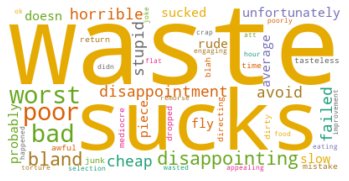

In [38]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_set, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[neg_inds])))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

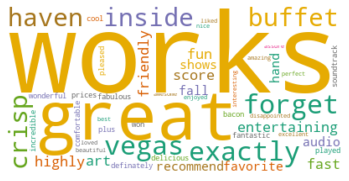

In [39]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_set, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[pos_inds])))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")    
plt.show()

### Predictions

In [40]:
print(clf.predict(vectorizer.transform(["It's a bad movie"])))

print(clf.predict(vectorizer.transform(["Waste of my time"])))

print(clf.predict(vectorizer.transform(["It is amazing"])))

print(clf.predict(vectorizer.transform(["It is not what I m looking for"])))

[0]
[0]
[1]
[0]
